In [1]:
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
import yfinance as yf

In [3]:
from datetime import date

In [4]:
df = yf.download('AAPL',start='2020-01-10',end=date.today().strftime('%Y-%m-%d')
)

/tmp/ipython-input-4-3420640873.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL',start='2020-01-10',end=date.today().strftime('%Y-%m-%d')
[*********************100%***********************]  1 of 1 completed


In [5]:
df.shape

(1387, 5)

In [6]:
#Get and print the last row of data
actual_price = df.tail(1)
actual_price

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-07-18,211.179993,211.789993,209.699997,210.869995,48939500


In [7]:
#prepare data for training the svr models
#Get all of the data except for the last row
df = df.head(len(df)-1)
print(df)

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2020-01-10   75.033875   75.599663   74.530960   75.099162  140644800
2020-01-13   76.636917   76.663518   75.232133   75.350614  121532000
2020-01-14   75.602089   76.784433   75.478782   76.574079  161954400
2020-01-15   75.278084   76.283920   74.845282   75.401398  121923600
2020-01-16   76.221039   76.332266   75.459410   75.822091  108829200
...                ...         ...         ...         ...        ...
2025-07-11  211.160004  212.130005  209.860001  210.570007   39765800
2025-07-14  208.619995  210.910004  207.539993  209.929993   38840100
2025-07-15  209.110001  211.889999  208.919998  209.220001   42296300
2025-07-16  210.160004  212.399994  208.639999  210.300003   47490500
2025-07-17  210.020004  211.800003  209.589996  210.570007   48068100

[1386 rows x 5 colu

In [8]:
#Create empty list to store the independent and dependent data
days = list()
close_prices = list()

In [9]:
df_close = df['Close']

In [10]:
#Create the independent data set
for i in range(len(df_close)):
  days.append([i])

In [11]:
#Create the dependent data set
for i in range(len(df_close)):
  # Use .iloc to access elements by their integer position
  close_prices.append(df_close.iloc[i])

In [12]:
#Create and train the Support Vector Regression model
days = np.reshape(days, (len(days),1))
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(days, close_prices)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000.0, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


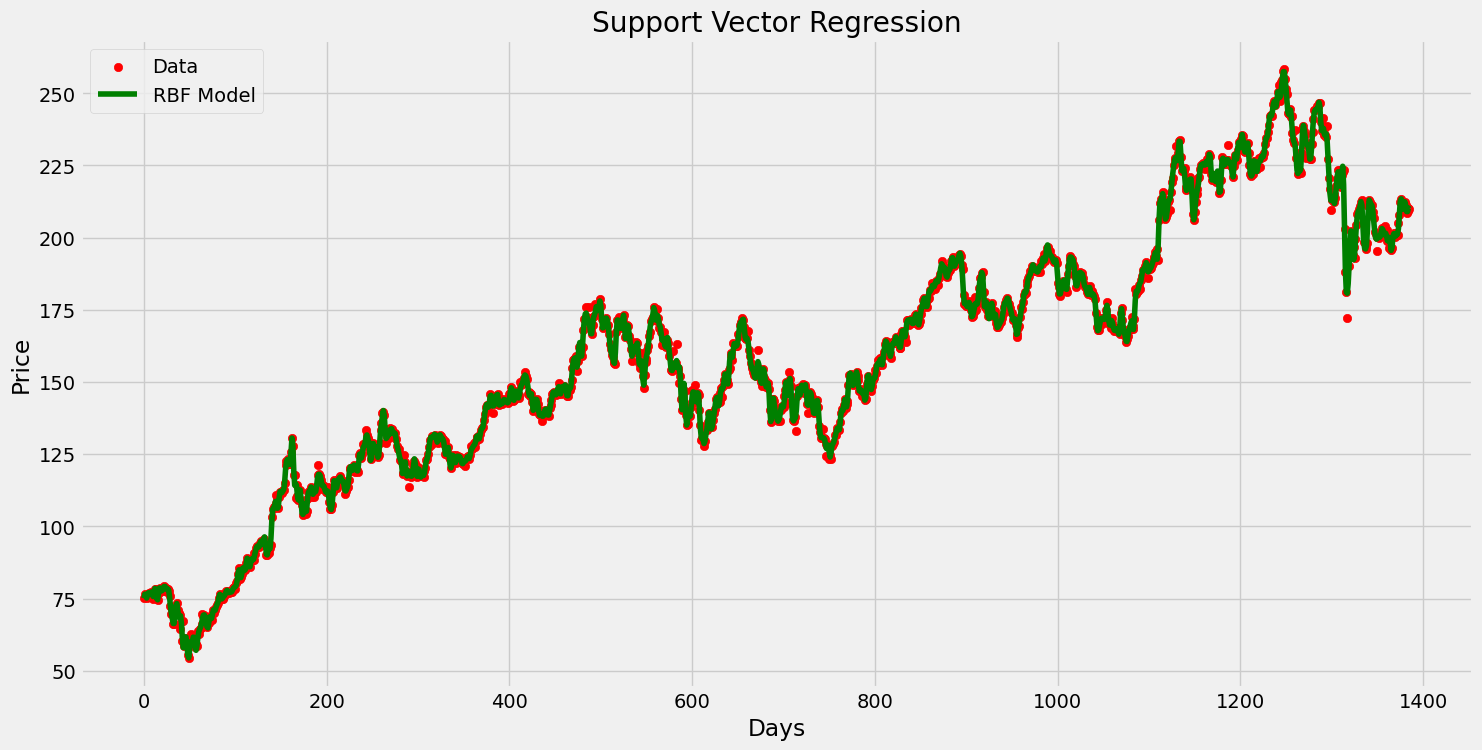

In [13]:
#Plot the models on a graph to see the SVR Prediction
plt.figure(figsize=(16,8))
plt.scatter(days, close_prices, color= 'red', label= 'Data')
plt.plot(days, svr_rbf.predict(days), color= 'green', label= 'RBF Model')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [14]:
#Show the predicted price
day = [[len(days)]]
print('The predicted price for the next day is: ', svr_rbf.predict(day))


The predicted price for the next day is:  [205.78169613]


In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(days, close_prices, test_size=0.2, random_state=42)

# Train the SVR model on the training data
svr_rbf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svr_rbf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# Evaluate the model on the test data
from sklearn import metrics
mae_test = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (Test Set):', mae_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (Test Set):', mse_test)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (Test Set):', rmse_test)

accuracy_test = svr_rbf.score(X_test, y_test)
print('Accuracy (Test Set):', accuracy_test)

Mean Absolute Error (Test Set): 2.048607253913173
Mean Squared Error (Test Set): 7.9442562603120574
Root Mean Squared Error (Test Set): 2.818555704667207
Accuracy (Test Set): 0.9959688784313567


In [17]:
import gradio as gr

In [18]:
def predict_stock_price(high, low, open_price, volume):
  """
  Predicts the stock's closing price using the trained svr_rbf model.

  Args:
    high (float): The high price for the day.
    low (float (float): The low price for the day.
    open_price (float): The opening price for the day.
    volume (int): The trading volume for the day.

  Returns:
    float: The predicted closing price.
  """
  # Create a DataFrame with the input features in the same order as the training data
  input_data = pd.DataFrame([[high, low, open_price, volume]],
                            columns=['High', 'Low', 'Open', 'Volume'])
  prediction = svr_rbf.predict(input_data)
  return prediction[0]

In [19]:
# Define the Gradio interface
interface = gr.Interface(
    fn=predict_stock_price, # Your prediction function
    inputs=[
        gr.Number(label="High Price"),
        gr.Number(label="Low Price"),
        gr.Number(label="Open Price"),
        gr.Number(label="Volume")
    ],
    outputs=gr.Number(label="Predicted Close Price"),
    title="Stock Price Predictor (Support Vector Regression )",
    description="Enter the High, Low, Open, and Volume to predict the Close price."
)

In [20]:
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://00c97ef839613ee40c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
